# **FRP Code Workflow Notebook**

### **Purpose**
Calculate cumulatve fire radiative power (cumFRP in W/Km^2) from an active fire detection source (AFD), for a specific area of interest (AOI), using a fire perimeter data set to bound detection.

### **Inputs**
**Active Fire Detection:** VIIRS

**Area of interest (AOI):** Southern Rockies Ecoregion

**Fire Perimeters:** FIRED (post-processed 5/11)

### **Outputs**
[WIP]

### **Author Acknowledgement**
Maxwell Cook (maxwell.cook@colorado.edu) created the original workflow and methods for aggregating FRP

Nate Hofford (nate.hofford@colorado.edu) modified this original workflow to be compatible with various AFDs, AOIs, and fire perimeters

## **Step 0: Set working directory and import python libraries**

In [1]:
## Imports
import sys, os, math
import xarray as xr
import geopandas as gpd
import fiona # specific for reading in .gpd files (like Welty and Jeffries)
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
import re

from pathlib import Path
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from rasterio.features import rasterize
from tqdm.notebook import tqdm


## Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N


## Working directories
# File path information
_current_cwd = Path.cwd().resolve() # Get current working directory at the start of this cell
_projdir_path = None

# Running from code dir
# This is common if the notebook is in 'code/' and Jupyter's CWD is the notebook's directory.
if _current_cwd.name == 'code':
    _parent_dir = _current_cwd.parent
    # Verify that this parent directory indeed contains the 'code' directory (which is _current_cwd)
    if (_parent_dir / 'code').exists() and (_parent_dir / 'code').resolve().samefile(_current_cwd.resolve()):
        _projdir_path = _parent_dir

# Running from root dir
# This is common if Jupyter is started from the project root.
elif (_current_cwd / 'code').is_dir():
    _projdir_path = _current_cwd

# Error handling
if _projdir_path is None:
    print(f"WARNING: Could not automatically determine project root using standard heuristics from CWD: {_current_cwd}.")
    print(f"Defaulting projdir: If CWD is 'code', its parent is used. Otherwise, CWD itself ('{_current_cwd}') is used.")
    if _current_cwd.name == 'code':
        _projdir_path = _current_cwd.parent
    else:
        _projdir_path = _current_cwd # Assume CWD is project root as a last resort

projdir = str(_projdir_path.resolve()) # Ensure projdir is an absolute string path

# Add the 'code' directory (expected to be projdir/code/) to sys.path
_custom_functions_path = os.path.join(projdir, 'code')
if _custom_functions_path not in sys.path:
    sys.path.insert(0, _custom_functions_path)

# Set Current Working Directory to Project Directory
if Path.cwd().resolve() != Path(projdir).resolve():
    os.chdir(projdir)
    print(f"Project directory set to: {projdir}")
    print(f"Changed working directory to project root: {os.getcwd()}")
else:
    print(f"Project directory set to: {projdir}")
    print(f"Working directory is already project root: {os.getcwd()}")

# Output directories
dataAFD = os.path.join(projdir,'data/output/AFD')
dataFires = os.path.join(projdir,'data/output/firePerimeters')

# Custom functions
from __functions import *


## You done and this is good to go
print("Ready !")

Project directory set to: C:\Users\naho5798\Documents\FIRED-frp
Changed working directory to project root: C:\Users\naho5798\Documents\FIRED-frp
Ready !


In [11]:
## Code to re-run if there were any edits to the __functions.py file
import importlib
import __functions
importlib.reload(__functions)
from __functions import *  # re-import everything

## **Step 1: Choose an area of interest (AOI)**

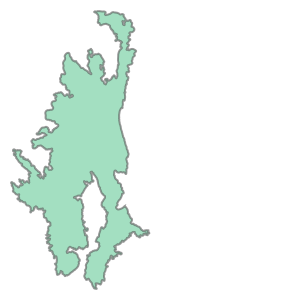

In [2]:
# Southern Rockies ecoregion bounds (buffered)
# SRM layer CRS --> EPSG:5070
fp = os.path.join(projdir,'data/input/AOI/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# calculate the total bounds with a 10km buffer
bounds = srm.geometry.unary_union.envelope.buffer(10000) # buffer in m
srm.geometry.unary_union

## **Step 2: Choose a fire perimeter dataset**

In this example, we are using **FIRED v2 (5/11)**

In [4]:
## Used FIRED CONUS perimeters
# Load and tidy the fire perimeter data
fp = os.path.join(projdir,'data/input/firePerimeters/FIRED/fired_conus_ak_2000_to_2025_events_merged.gpkg')
fires = gpd.read_file(fp)

print(fires.columns)

Index(['merge_id', 'ig_date', 'ig_day', 'ig_year', 'ig_month', 'last_date',
       'tot_ar_km2', 'tot_ar_ac', 'fsr_km2_dy', 'mx_grw_km2', 'eco_mode',
       'eco_name', 'eco_type', 'member_ids', 'first_ig_date', 'lrg_ig_date',
       'mx_grw_dte', 'ig_utm_x', 'ig_utm_y', 'member_count', 'event_dur',
       'geometry'],
      dtype='object')


## **Step 2a (cont): Extract relevant columns and dates**

In [5]:
## FIRED Specific Values

## Needed to change the columns here for FIRED specific values
# tidy the date columns
## DISCOVERY_DATE
fires['ig_date'] = pd.to_datetime(fires['ig_date'])
## WF_CESSATION_DATE
fires['last_date'] = pd.to_datetime(fires['last_date'])
## Final_Acres = now will be km2
fires['tot_ar_km2'] = fires['tot_ar_km2'].astype(float)
## ICS_ACRES
#fires['ICS_ACRES'] = fires['ICS_ACRES'].astype(float)

# subset the columns
#fires = fires[['Fire_ID','Fire_Name','Final_Acres',
#               'INCIDENT_ID','START_YEAR','DISCOVERY_DATE',
#               'WF_CESSATION_DATE','ICS_ACRES','geometry']]

# subset the columns
fires = fires[['merge_id','tot_ar_km2','ig_year','ig_date',
               'last_date','geometry']]

# remove any duplicates (the RYAN fire was duplicated for some reason)
fires = fires.drop_duplicates(subset='merge_id', keep='first')

## **Step 3a: Filter fire perimeters for AOI**

In [6]:
# Ensure the CRS matches between fires and SRM
if fires.crs != srm.crs:
    srm = srm.to_crs(fires.crs)

# Create a single unified geometry for the SRM region
srm_union = srm.geometry.unary_union

# Filter fires to those that intersect the Southern Rockies
fires_srm = fires[fires.geometry.intersects(srm_union)].copy()

# Export
fires_srm.to_file(os.path.join(dataFires,"fires_wj.gpkg"))

# Print
print(f"Filtered fires to {len(fires_srm)} records that intersect the Southern Rockies.")


Filtered fires to 1330 records that intersect the Southern Rockies.


## **Step 3b: Buffer fire perimeters**

In [15]:
# Now buffer only the relevant fires
buffer_dist = 3000  # meters
fires_srm['geometry'] = fires_srm.geometry.buffer(buffer_dist)

# Export
fires_srm.to_file(os.path.join(dataFires,"fires_FIRED_buffered.gpkg"))

# Print number of fires in the AOI
print(f"Buffered {len(fires_srm)} wildfire perimeters by {buffer_dist/1000} km.")


Buffered 1330 wildfire perimeters by 3.0 km.


## **Step 4: Choose active fire detection (AFD) dataset**

In this example, we are using **VIIRS**.

In [16]:
# Display csv to see data structure
df = pd.read_csv("data/input/AFD/VIIRS/fire_nrt_J1V-C2_603779.csv")

# Show the first few rows
print(df.head())

   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0  41.89173  -83.35799      312.67  0.43   0.38  2025-02-01       713   
1  41.73209  -83.52107      295.03  0.44   0.38  2025-02-01       713   
2  41.46272  -81.67390      329.13  0.39   0.36  2025-02-01       713   
3  41.45276  -81.67643      320.67  0.39   0.36  2025-02-01       713   
4  43.31004  -85.30531      302.98  0.53   0.42  2025-02-01       713   

  satellite instrument confidence version  bright_t31   frp daynight  
0       N20      VIIRS          n  2.0NRT      271.58  2.04        N  
1       N20      VIIRS          n  2.0NRT      267.56  0.32        N  
2       N20      VIIRS          n  2.0NRT      275.70  6.29        N  
3       N20      VIIRS          n  2.0NRT      272.05  1.76        N  
4       N20      VIIRS          n  2.0NRT      266.21  0.70        N  


## **Step 4a: Data cleaning**

- Remove duplicate observations within each satellite across archived (higher quality) and NRT (near real time, so less processing) 

In [17]:
# File paths for the NRT and Archive data files
nrt_files = {
    'J1V-C2': 'data/input/AFD/VIIRS/fire_nrt_J1V-C2_603779.csv',
    'J2V-C2': 'data/input/AFD/VIIRS/fire_nrt_J2V-C2_603780.csv',
    'SV-C2': 'data/input/AFD/VIIRS/fire_nrt_SV-C2_603781.csv'
    }

archive_files = {
    'J1V-C2': 'data/input/AFD/VIIRS/fire_archive_J1V-C2_603779.csv',
    'SV-C2': 'data/input/AFD/VIIRS/fire_archive_SV-C2_603781.csv'
    }

# Function to process and deduplicate data files within each satellite
def process_and_deduplicate(nrt_file, archive_file, satellite_type):
    # Read the NRT and Archive data files
    nrt_data = pd.read_csv(nrt_file)
    archive_data = pd.read_csv(archive_file)

    # Add source and satellite type columns
    nrt_data['source'] = 'NRT'
    archive_data['source'] = 'Archive'
    nrt_data['satellite_type'] = satellite_type
    archive_data['satellite_type'] = satellite_type

    # Concatenate NRT and Archive data
    combined_data = pd.concat([nrt_data, archive_data])

    # Format acquisition time to HHMM and convert date + time to datetime
    combined_data['acq_time'] = combined_data['acq_time'].astype(str).str.zfill(4)
    combined_data['acq_datetime'] = pd.to_datetime(
        combined_data['acq_date'].astype(str) + ' ' +
        combined_data['acq_time'].str[:2] + ':' +
        combined_data['acq_time'].str[2:] + ':00',
        format='%Y-%m-%d %H:%M:%S'
    )

    # Count duplicates before removing them
    duplicates_mask = combined_data.duplicated(subset=['latitude', 'longitude', 'acq_datetime'], keep=False)
    duplicates_count = duplicates_mask.sum()
    print(f"Number of duplicates in {satellite_type}: {duplicates_count}")

    # Deduplicate, prioritizing Archive data
    deduplicated_data = combined_data.sort_values(by=['acq_datetime', 'source'], ascending=[False, True])
    deduplicated_data = deduplicated_data.drop_duplicates(subset=['latitude', 'longitude', 'acq_datetime'], keep='first')

    return deduplicated_data

# Define the path for the final output file
final_csv_path = 'data/input/AFD/VIIRS/VIIRS_cat.csv'

# Check if the final deduplicated file already exists
if os.path.exists(final_csv_path):
    print("Deduplicated and concatenated data already exists!")
else:
    # Process each satellite type
    deduplicated_datasets = []

    for satellite_type, nrt_file in nrt_files.items():
        archive_file = archive_files.get(satellite_type)
        if archive_file:
            deduplicated_data = process_and_deduplicate(nrt_file, archive_file, satellite_type)
            deduplicated_datasets.append(deduplicated_data)

    # Combine all deduplicated datasets
    if deduplicated_datasets: # Check if there's any data to concatenate
        VIIRS_cat = pd.concat(deduplicated_datasets)

        # Save the final deduplicated dataset
        VIIRS_cat.to_csv(final_csv_path, index=False)
        print("All satellite data processed and deduplicated successfully!")
    else:
        print("No data to process or combine.")

Deduplicated and concatenated data already exists!


In [18]:
# load the AFD data from the VIIRS censors
fp = os.path.join('data/input/AFD/VIIRS/VIIRS_cat.csv')
afds = pd.read_csv(fp, dtype={'version': str}).reset_index(drop=True)
afds = afds.loc[:, ~afds.columns.str.startswith('Unnamed:')]
print(f"Number of fire detections: {len(afds)}")
afds.dtypes

Number of fire detections: 10666424


latitude          float64
longitude         float64
brightness        float64
scan              float64
track             float64
acq_date           object
acq_time            int64
satellite          object
instrument         object
confidence         object
version            object
bright_t31        float64
frp               float64
daynight           object
source             object
satellite_type     object
type              float64
acq_datetime       object
dtype: object

In [19]:
# drop low confidence detections

## NH: potentially keep this step or keep all the fires and allow people to filter after by keeping the confidence column
N = len(afds)
print(afds['confidence'].value_counts())
afds = afds[afds['confidence'] != 'l']
print(f"\nDropped {N-len(afds)} [{round(((N-len(afds))/N)*100,2)}%] low-confidence obs.\n")

confidence
n    9628438
h     580529
l     457457
Name: count, dtype: int64

Dropped 457457 [4.29%] low-confidence obs.



## **Step 5: Join AFD and fire perimeters**

In [20]:
# Create spatial points from lat/lon
from shapely.geometry import Point

# convert to spatial points using pixel centroid
afds['geometry'] = [Point(xy) for xy in zip(afds.longitude, afds.latitude)]
afds_ll = gpd.GeoDataFrame(afds, geometry='geometry', crs="EPSG:4326")
afds_ll = afds_ll.to_crs("EPSG:5070")
afds_ll = afds_ll.reset_index(drop=True)
afds_ll['afdID'] = afds_ll.index # add a unique ID
print(afds_ll[['longitude', 'latitude', 'confidence', 'frp', 'acq_date', 'acq_time', 'daynight', 'satellite']].head())

# spatially subset the SRM extent
afds_ll = afds_ll[afds_ll.geometry.within(bounds)]
print(f"\n[{len(afds_ll)}({round(len(afds_ll)/len(afds)*100,2)}%)] detections in the Southern Rockies.")

print(afds_ll.columns.tolist())


# save this file out.
## Do a spatial join with these points to see the % that overlaps with FIRED perims
out_fp = os.path.join(dataAFD,'viirs_snpp_jpss1_afdFIRED_latlon_srm.gpkg')
afds_ll.to_file(out_fp)
print(f"\nSaved spatial points to: {out_fp}\n")

   longitude  latitude confidence    frp    acq_date  acq_time daynight  \
0  -70.64477  41.82554          n  25.15  2025-04-17      1650        D   
1  -76.38818  40.23703          n   6.69  2025-04-17      1650        D   
2  -76.38847  40.24114          n   7.40  2025-04-17      1650        D   
3  -74.56175  41.19677          n   3.64  2025-04-17      1650        D   
4  -74.57194  41.20029          n   3.64  2025-04-17      1650        D   

  satellite  
0       N20  
1       N20  
2       N20  
3       N20  
4       N20  

[221968(2.17%)] detections in the Southern Rockies.
['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'source', 'satellite_type', 'type', 'acq_datetime', 'geometry', 'afdID']

Saved spatial points to: C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD\viirs_snpp_jpss1_afdFIRED_latlon_srm.gpkg



## **Step 6: Join AFD and fire perimeters and remove AFD detection duplicates**

In [21]:
# Make sure both fire perims and AFD observations are in the same CRS
fires_srm = fires_srm.to_crs(afds_ll.crs)

# spatially join to the fire perimeters
# retain a subset of fire columns in the join
afds_ll_fires = gpd.sjoin(
    afds_ll, fires_srm[['merge_id','tot_ar_km2','ig_year','ig_date',
               'last_date','geometry']], 
    how='inner', 
    predicate='within'
).drop(columns=['index_right']) # drop the join index column

# check for duplicate rows (same AFD, multiple fires)
## NH: removing the smallest duplicate appropriate or is there a better way to handle these VIIRS duplictes?
duplicates = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"\nResolving [{len(duplicates)}/{len(afds_ll_fires)}] duplicate obs.\n")

# create an acquisition datetime column
# set the time in MST as well
# see __functions.py
afds_ll_fires['acq_dt_mst'] = afds_ll_fires.apply(
    lambda row: convert_datetime(
        row['acq_date'], 
        row['acq_time'], 
        zone='America/Denver' # MST
    ), axis=1
)

# tidy & prep the temporal information
afds_ll_fires['acq_date'] = pd.to_datetime(afds_ll_fires['acq_date'])
afds_ll_fires['acq_month'] = afds_ll_fires['acq_date'].dt.month.astype(int) # extract the month
afds_ll_fires['acq_year'] = afds_ll_fires['acq_date'].dt.year.astype(int) # extract the year
# filter the AFDs by temporal matches to their fire event
# identify observations within 14 days of ignition/cessation
afds_ll_fires = afds_ll_fires[
    (afds_ll_fires['acq_date'] >= afds_ll_fires['ig_date'] - timedelta(days=14)) &
    (afds_ll_fires['acq_date'] <= afds_ll_fires['last_date'] + timedelta(days=14))
]

print(afds_ll_fires.columns.tolist())

# re-check duplicates
duplicates = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"\t[{len(duplicates)}] remaining duplicate 'afdID'.\n")
del duplicates
gc.collect()


Resolving [973192/995274] duplicate obs.

['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'source', 'satellite_type', 'type', 'acq_datetime', 'geometry', 'afdID', 'merge_id', 'tot_ar_km2', 'ig_year', 'ig_date', 'last_date', 'acq_dt_mst', 'acq_month', 'acq_year']
	[29076] remaining duplicate 'afdID'.



32

In [25]:
duplicates = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"\t[{len(duplicates)}] remaining duplicate 'afdID'.\n")
duplicates.to_file(os.path.join(dataAFD,"duplicateFIRED_afds.gpkg"))

# Explore duplicates further
#print(duplicates[['afdID','id','tot_ar_km2','longitude', 'latitude', 'confidence', 'frp', 'acq_date', 'acq_time', 'daynight', 'satellite']].head())

# How many unique afdIDs
print(duplicates['afdID'].nunique)

# Area difference between duplicates
duplicates['dupDif'] = duplicates.groupby('afdID')['tot_ar_km2'].transform(lambda x: x.max() - x.min())
print(duplicates[['afdID','merge_id','tot_ar_km2','dupDif']].head())

# Sort by 'Age' in descending order
sorted_dups = duplicates.sort_values(by='dupDif', ascending=False)
print(sorted_dups[['afdID','merge_id','tot_ar_km2','dupDif']])

	[29076] remaining duplicate 'afdID'.

<bound method IndexOpsMixin.nunique of 137107        137107
137107        137107
137108        137108
137108        137108
775763        775763
              ...   
10062253    10062253
10062254    10062254
10062254    10062254
10062255    10062255
10062255    10062255
Name: afdID, Length: 29076, dtype: int64>
         afdID  merge_id  tot_ar_km2    dupDif
137107  137107   46666.0    0.429317  0.214659
137107  137107   46687.0    0.214659  0.214659
137108  137108   46666.0    0.429317  0.214659
137108  137108   46687.0    0.214659  0.214659
775763  775763   51202.0    1.717269  0.858635
           afdID  merge_id  tot_ar_km2      dupDif
2495426  2495426   47443.0    0.214659  727.692902
2495426  2495426   47472.0    0.643976  727.692902
2495426  2495426  199896.0  727.907561  727.692902
2495427  2495427   47443.0    0.214659  727.692902
2512489  2512489   47443.0    0.214659  727.692902
...          ...       ...         ...         ...
9750696  9

In [26]:
## IMPORTANT: HERE WE REMOVE DUPLICATES BY ONLY KEEPING THE AFD ASSOCIATED WITH THE LARGER FIRE PERIM
print(f"\nNumber of rows in afds_ll_fires before 'afdID' deduplication (keeping largest fire): {len(afds_ll_fires)}")

# Sort by afdID and then by tot_ar_km2 (descending) to ensure the largest area comes first for each afdID
afds_ll_fires = afds_ll_fires.sort_values(['afdID', 'tot_ar_km2'], ascending=[True, False])

# Drop duplicates based on afdID, keeping the first occurrence (which now has the largest tot_ar_km2)
afds_ll_fires = afds_ll_fires.drop_duplicates(subset='afdID', keep='first')

# Print number of rows after deduplication
print(f"Number of rows in afds_ll_fires after 'afdID' deduplication: {len(afds_ll_fires)}")

# Verify that there are no more duplicates for 'afdID'
remaining_duplicates_check = afds_ll_fires[afds_ll_fires.duplicated(subset='afdID', keep=False)]
print(f"Number of 'afdID' groups with multiple entries after removal: {len(remaining_duplicates_check)}\n")



Number of rows in afds_ll_fires before 'afdID' deduplication (keeping largest fire): 164519
Number of rows in afds_ll_fires after 'afdID' deduplication: 149576
Number of 'afdID' groups with multiple entries after removal: 0



In [27]:
# print out the day/night times in MST
day_obs = afds_ll_fires[afds_ll_fires['daynight'] == 'D']
day_obs['acq_time_mst'] = day_obs['acq_dt_mst'].dt.time
print(f"\nFirst MST datetime for 'Day': {day_obs['acq_time_mst'].min()}")
print(f"Last MST datetime for 'Day': {day_obs['acq_time_mst'].max()}\n")

# check on nighttime datetimes
night_obs = afds_ll_fires[afds_ll_fires['daynight'] == 'N']
night_obs['acq_time_mst'] = night_obs['acq_dt_mst'].dt.time
print(f"First MST datetime for 'Night': {night_obs['acq_time_mst'].min()}")
print(f"Last MST datetime for 'Night': {night_obs['acq_time_mst'].max()}\n")
del night_obs, day_obs
gc.collect()


First MST datetime for 'Day': 11:40:00
Last MST datetime for 'Day': 15:19:00

First MST datetime for 'Night': 01:05:00
Last MST datetime for 'Night': 04:20:00



1546

## **Step 6a: Remove scan duplicates**

In [29]:
# handle duplicates caused by the adjacent scan overlap
from scipy.spatial import cKDTree # for distance matrix
# same datetime, distance between detections smaller than the along_track distance
drop_obs = set() # unique detections to drop
# Group observations by Fire_ID and acquisition datetime
## Changed to identify by FIRED id which is just an integer
dt_groups = afds_ll_fires.groupby(['merge_id', 'acq_dt_mst'])
print(f"\nNumber of unique (FIRED merge_id, acq_datetime) groups: {len(dt_groups)}\n")

# process the datetime groups
def process_afd_duplicates(group):
    """Identify duplicates in a FIRED merge_id/datetime group using KDTree"""
    if len(group) <= 1:
        return  # Skip groups with a single point
    # Extract point coordinates and thresholds
    coords = np.array([[geom.x, geom.y] for geom in group.geometry])
    thresholds = group['track'].values / 2 * 1000  # Convert along-track distance to meters
    # Build a KDTree for the group points
    tree = cKDTree(coords)

    # Query KDTree for neighbors within the maximum threshold distance
    for i, (coord, threshold) in enumerate(zip(coords, thresholds)):
        if group.iloc[i]['afdID'] in drop_obs:
            continue  # Skip already marked duplicates
        
        # Find neighbors within the threshold distance
        neighbor_idxs = tree.query_ball_point(coord, threshold)

        # Compare with neighbors and flag duplicates
        for j in neighbor_idxs:
            if i == j or group.iloc[j]['afdID'] in drop_obs:
                continue  # Skip self-comparison and already marked duplicates
            
            # Compare FRP values to determine which detection to drop
            if group.iloc[j]['frp'] < group.iloc[i]['frp']:
                drop_obs.add(group.iloc[j]['afdID'])  # Drop the neighbor
            else:
                drop_obs.add(group.iloc[i]['afdID'])  # Drop the current point
                break  # Stop further checks for this point

# Process each group efficiently
for (fire_id, datetime), group in dt_groups:
    process_afd_duplicates(group)
print(f"Identified [{len(drop_obs)} ({round(len(drop_obs)/len(afds_ll_fires)*100,2)}%)] duplicates.\n")
# Remove duplicates from processing
afds_ll_fires = afds_ll_fires[~afds_ll_fires['afdID'].isin(drop_obs)]
print(f"\t[{len(afds_ll_fires)}] remaining detections.\n")


Number of unique (FIRED merge_id, acq_datetime) groups: 5271

Identified [13734 (9.18%)] duplicates.

	[135842] remaining detections.



## **Step 7: Observation counts and FRP historgram --> need to chunk better**

   merge_id  count
0   46666.0      2
1   46804.0      9
2   46817.0      8
3   46906.0   1878
4   46924.0     22
Index(['merge_id', 'count'], dtype='object')

 count    135842.000000
mean       8910.811649
std        8126.422379
min           1.000000
25%        1554.000000
50%        5234.000000
75%       17395.000000
max       22088.000000
Name: count, dtype: float64 

10th percentile count: 413.0 



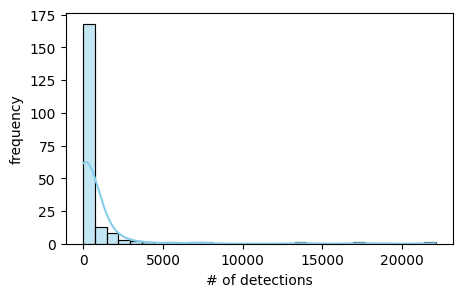

In [30]:
# grab a count of observations for each fire
counts = afds_ll_fires.groupby(['merge_id']).size().reset_index(name='count')

print(counts.head())
print(counts.columns)

afds_ll_fires = pd.merge(afds_ll_fires, counts, on='merge_id', how='left')

# print some statistics
print("\n", afds_ll_fires['count'].describe(), "\n")
print(f"10th percentile count: {afds_ll_fires['count'].quantile(0.10)}", "\n") 

# plot the distribution
plt.figure(figsize=(5, 3))  # Set figure size
sns.histplot(counts['count'], bins=30, kde=True, color='skyblue')
plt.xlabel('# of detections', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.show()


count    135842.000000
mean         23.278054
std          54.396921
min           0.000000
25%           2.170000
50%           5.640000
75%          18.860000
max        1909.180000
Name: frp, dtype: float64

	Removed [365] observations with FRP == 0


count    135477.000000
mean        106.744270
std         249.179182
min           0.910010
25%          10.403917
50%          26.503238
75%          86.680912
max        8954.878049
Name: frp_wkm2, dtype: float64

     frp    frp_wkm2  pix_area
0   7.92   46.153846    0.1716
1  82.87  482.925408    0.1716
2   1.42    7.395833    0.1920 



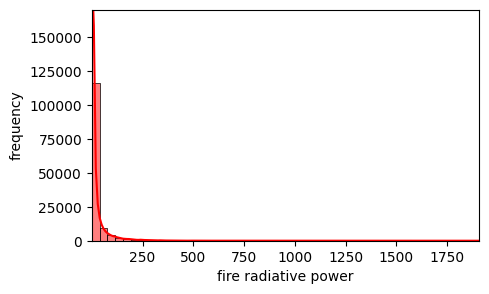

In [31]:
## Quickly calculate pix_area by multiplying scan and track
afds_ll_fires['pix_area'] = afds_ll_fires['scan'] * afds_ll_fires['track']

# check on the FRP measurements
# identify observations with 0 FRP
print(f"\n{afds_ll_fires['frp'].describe()}\n")
# drop 0 records (no FRP measurements)
n_zero = afds_ll_fires[afds_ll_fires['frp'] == 0]['frp'].count()
afds_ll_fires = afds_ll_fires[afds_ll_fires['frp'] > 0]
print(f"\tRemoved [{n_zero}] observations with FRP == 0\n")

# create a "W/Km2" column, dividing FRP by pixel area
afds_ll_fires['frp_wkm2'] = afds_ll_fires['frp'] / afds_ll_fires['pix_area']
print(f"\n{afds_ll_fires['frp_wkm2'].describe()}\n")
print(afds_ll_fires[['frp','frp_wkm2','pix_area']].head(3), "\n")

# plot the distribution
x_min, x_max = afds_ll_fires['frp'].min(), afds_ll_fires['frp'].max()
plt.figure(figsize=(5, 3))  # Set figure size
sns.histplot(afds_ll_fires['frp'], bins=50, kde=True, color='red')
plt.xlim(x_min, x_max)
plt.ylim(0, 170000)
plt.xlabel('fire radiative power', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.show()

In [33]:
# check on some detections thresholds by fire
print(f">=10 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 10]['merge_id'].unique())}")
print(f">=50 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 50]['merge_id'].unique())}")
print(f">=100 obs: {len(afds_ll_fires[afds_ll_fires['count'] >= 100]['merge_id'].unique())}")

>=10 obs: 170
>=50 obs: 111
>=100 obs: 84


In [34]:
# only keep fires with enough detections
n_obs = 10 # the threshold for number of observations
afds_fires = afds_ll_fires[afds_ll_fires['count'] >= n_obs]
print(f"There are {len(afds_fires['merge_id'].unique())} fires with >= {n_obs} obs.")

There are 170 fires with >= 10 obs.


In [35]:
# save this file out.
out_fp = os.path.join(dataAFD,'viirs_snpp_jpss1_afd_latlon_FIREDfires.gpkg')
afds_fires.to_file(out_fp)
print(f"Saved spatial points to: {out_fp}")

Saved spatial points to: C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD\viirs_snpp_jpss1_afd_latlon_FIREDfires.gpkg


In [36]:
# tidy up
del afds_ll_fires, afds_ll
gc.collect()

2187

## **Step 9: Convert AFD to pixel area dataset**

In [37]:
# Create the ground area of pixels based on swath position
# Define the pixel buffer function for the given width and height
def pixel_area(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

afds_pix = afds_fires.copy() # work on a copy of our lat/lon detections

# Apply the buffer function with along_scan and along_track values converted to meters (*1000)
afds_pix["geometry"] = afds_pix.apply(
    lambda row: pixel_area(row["geometry"], row["scan"] * 1000, row["track"] * 1000), axis=1
)

# tidy the index column
afds_pix = afds_pix.reset_index(drop=True)
afds_pix['obs_id'] = afds_pix.index # unique ID column
print(f"Total detections at this stage: {len(afds_pix)}")
print(f"\nColumns available:\n {afds_pix.columns}\n")
afds_pix[['longitude', 'latitude', 'confidence', 'frp',
          'acq_date', 'acq_time', 'acq_dt_mst', 'daynight', 'satellite']].head() # check the results

Total detections at this stage: 135312

Columns available:
 Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'source', 'satellite_type', 'type',
       'acq_datetime', 'geometry', 'afdID', 'merge_id', 'tot_ar_km2',
       'ig_year', 'ig_date', 'last_date', 'acq_dt_mst', 'acq_month',
       'acq_year', 'count', 'pix_area', 'frp_wkm2', 'obs_id'],
      dtype='object')



,longitude,latitude,confidence,frp,acq_date,acq_time,acq_dt_mst,daynight,satellite
0,-107.49272,39.12046,n,1.42,2024-12-05,844,2024-12-05 01:44:00-07:00,N,N20
1,-107.47883,39.11893,n,34.74,2024-12-04,2024,2024-12-04 13:24:00-07:00,D,N20
2,-107.48482,39.11827,n,34.74,2024-12-04,2024,2024-12-04 13:24:00-07:00,D,N20
3,-107.49080,39.11760,n,53.82,2024-12-04,2024,2024-12-04 13:24:00-07:00,D,N20
4,-107.49162,39.12133,n,53.82,2024-12-04,2024,2024-12-04 13:24:00-07:00,D,N20


In [38]:
# save this file out.
out_fp = os.path.join(dataAFD,'viirs_snpp_jpss1_afd_latlon_firesFIRED_pixar.gpkg')
afds_pix.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD\viirs_snpp_jpss1_afd_latlon_firesFIRED_pixar.gpkg



In [39]:
# Subset fires to the grid dataset
fires = fires[fires['merge_id'].isin(afds_pix['merge_id'].unique())]
# export the new fire census
print(f"Exporting {len(fires)}")
out_fp = os.path.join(dataFires,'srm_fireFIRED_census_2000_to_2024_subset.gpkg')
fires.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Exporting 170
Saved file to: C:\Users\naho5798\Documents\FIRED-frp\data/output/firePerimeters\srm_fireFIRED_census_2000_to_2024_subset.gpkg


## **Step 10: Aggregate FRP to a regular grid**

In [40]:
# Aggregate FRP to a regular grid
t0 = time.time()

# create a regular grid extracted to fire perimeters
def regular_grid(extent, res=0.0035, crs_out='EPSG:5070', regions=None):
    """
    Creates a regular-spaced grid
    """
    # retrieve bounding coordinates
    min_lon, max_lon, min_lat, max_lat = extent
    
    # create the grid lines in degrees
    x_coords = np.arange(min_lon, max_lon, res)
    y_coords = np.arange(min_lat, max_lat, res)

    # generate the grid cells
    cells = [
        Polygon([(x, y), (x + res, y), (x + res, y + res), (x, y + res)])
        for x in x_coords for y in y_coords
    ]

    # create a geodataframe in WGS, reprojected if needed
    grid = gpd.GeoDataFrame({'geometry': cells}, crs=crs_out)

    if regions is not None:
        if regions.crs != grid.crs:
            regions = regions.to_crs(grid.crs)
        # Perform spatial intersection to keep only grid cells overlapping the polygon
        grid = grid[grid.intersects(regions.unary_union)].copy()

    return grid

# get the SRM extent in lat/lon (WGS)
coords, extent = get_coords(srm, buffer=1000, crs='EPSG:5070')
print(f"Bounding extent for the SRM: {extent}")

# generate the grid (0.0035 degrees or 375m)
# extract grid intersecting fire perimeters
grid = regular_grid(
    extent, # Southern Rockies
    res=375, # 375m2 (VIIRS at-nadir res)
    crs_out='EPSG:5070', # projected crs
    regions=fires # any overlapping detections
)

# save this out.
out_fp = os.path.join(dataFires, 'srm_fireFIRED_census_reggrid_375m.gpkg')
grid.to_file(out_fp, driver="GPKG")
print(f"Grid saved to: {out_fp}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

Bounding extent for the SRM: [-1112969.8538487973, -692084.1768479828, 1400547.678813619, 2244409.9246547585]
Grid saved to: C:\Users\naho5798\Documents\FIRED-frp\data/output/firePerimeters\srm_fireFIRED_census_reggrid_375m.gpkg

Total elapsed time: 4.22 minutes.


~~~~~~~~~~

Done!


## **Step 11: Calculate cumulative FRP**

In [41]:
# calculate a gridded cumulative FRP and maximum FRP
# process the fire data by aggregating fractional FRP
t0 = time.time()

def aggregate_frp(detections, grid):
    """
    Aggregate fire pixel frp data into a regular grid with fractional overlay
    """

    # Make sure the projections match
    if detections.crs != grid.crs:
        detections = detections.to_crs(grid.crs)

    # calculate the pixel area in m2
    detections['pix_area_m2'] = detections['pix_area'] * 1e6

    # tidy the grid and calculate the grid area
    grid = grid.reset_index(drop=False).rename(columns={'index': 'grid_index'})
    grid['grid_area'] = grid.geometry.area  # precompute grid cell areas

    # overlay detections onto the grid
    overlay = gpd.overlay(detections, grid, how='intersection')

    # fractional overlap area
    overlay['overlap_m2'] = overlay.geometry.area
    overlay['fraction'] = overlay['overlap_m2'] / overlay['pix_area_m2']
    
    # multiply FRP by fractional area
    overlay['frp_fr'] = overlay['frp_wkm2'] * overlay['fraction']
    overlay['frp_fr'] = overlay['frp_fr'].fillna(0)
    
    # Aggregate by grid cell
    aggregated = overlay.groupby('grid_index').agg(
        afd_count=('frp_fr', 'count'), 
        unique_days=('acq_date', 'nunique'),
        # overlap amount
        overlap=('fraction', 'sum'),
        # fire radiative power
        frp_csum=('frp_fr', 'sum'),
        frp_max=('frp_fr', 'max'),
        frp_min=('frp_fr', 'min'),
        frp_mean=('frp_fr', 'mean'),
        frp_p90=('frp_fr', lambda x: x.quantile(0.90) if not x.empty else 0),
        frp_p95=('frp_fr', lambda x: x.quantile(0.95) if not x.empty else 0),
        frp_p97=('frp_fr', lambda x: x.quantile(0.97) if not x.empty else 0),
        frp_p99=('frp_fr', lambda x: x.quantile(0.99) if not x.empty else 0),
        frp_first=('frp_fr', lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst').iloc[0]['frp_fr']),
        day_max_frp=('frp_fr', lambda x: overlay.loc[x.idxmax(), 'acq_date'] if not x.empty else None),
        dt_max_frp=('frp_fr', lambda x: overlay.loc[x.idxmax(), 'acq_dt_mst'] if not x.empty else None),
        first_obs_date=('acq_date', 'min'),
        last_obs_date=('acq_date', 'max') 
    ).reset_index()

    # add day and night FRP stats
    daynight_stats = (
        overlay.groupby(['grid_index', 'daynight'])['frp_fr']
        .agg(
            count='count',
            max='max', 
            mean='mean',
            sum='sum',
            p90=lambda x: x.quantile(0.90) if not x.empty else 0,
            p95=lambda x: x.quantile(0.95) if not x.empty else 0,
            p97=lambda x: x.quantile(0.97) if not x.empty else 0,
            p99=lambda x: x.quantile(0.99) if not x.empty else 0,
            first=lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst').iloc[0]['frp_fr'],
            last=lambda x: overlay.loc[x.index, :].sort_values('acq_dt_mst', ascending=False).iloc[0]['frp_fr']
        )
        .unstack(fill_value=0)  # Ensure missing values are filled with 0
        .reset_index()
    )

    #print(daynight_stats.columns)

    # Flatten column names after unstacking
    daynight_stats.columns = [
        f"{stat}_{dn}" if dn else stat
        for stat, dn in daynight_stats.columns
    ]

    # Rename flattened daynight_stats columns to match original naming convention
    rename_map = {
        'count_D': 'day_count',
        'count_N': 'night_count',
        'max_D': 'frp_max_day',
        'max_N': 'frp_max_night',
        'sum_D': 'frp_csum_day',
        'sum_N': 'frp_csum_night',
        'mean_D': 'frp_mean_day',
        'mean_N': 'frp_mean_night',
        'p90_D': 'frp_p90_day',
        'p90_N': 'frp_p90_night',
        'p95_D': 'frp_p95_day',
        'p95_N': 'frp_p95_night',
        'p97_D': 'frp_p97_day',
        'p97_N': 'frp_p97_night',
        'p99_D': 'frp_p99_day',
        'p99_N': 'frp_p99_night',
        'first_D': 'frp_first_day',
        'first_N': 'frp_first_night',
        'last_D': 'frp_last_day',
        'last_N': 'frp_last_night'
    }
    
    daynight_stats = daynight_stats.rename(columns=rename_map)

    # Merge the flattened daynight_stats back in on 'grid_index'
    aggregated = aggregated.merge(daynight_stats, on='grid_index', how='left')

    # Fill missing values (if any grid cell lacks day/night data)
    aggregated = aggregated.fillna(0)
    
    # Add day/night statistics
    #aggregated['day_count'] = daynight_stats['count'].get('D', 0)
    #aggregated['night_count'] = daynight_stats['count'].get('N', 0)
    #aggregated['frp_max_day'] = daynight_stats['max'].get('D', 0)
    #aggregated['frp_max_night'] = daynight_stats['max'].get('N', 0)
    #aggregated['frp_csum_day'] = daynight_stats['sum'].get('D', 0)
    #aggregated['frp_csum_night'] = daynight_stats['sum'].get('N', 0)
    #aggregated['frp_mean_day'] = daynight_stats['mean'].get('D', 0)
    #aggregated['frp_mean_night'] = daynight_stats['mean'].get('N', 0)
    #aggregated['frp_p90_day'] = daynight_stats['p90'].get('D', 0)
    #aggregated['frp_p90_night'] = daynight_stats['p90'].get('N', 0)
    #aggregated['frp_p95_day'] = daynight_stats['p95'].get('D', 0)
    #aggregated['frp_p95_night'] = daynight_stats['p95'].get('N', 0)
    #aggregated['frp_p97_day'] = daynight_stats['p97'].get('D', 0)
    #aggregated['frp_p97_night'] = daynight_stats['p97'].get('N', 0)
    #aggregated['frp_p99_day'] = daynight_stats['p99'].get('D', 0)
    #aggregated['frp_p99_night'] = daynight_stats['p99'].get('N', 0)
    #aggregated['frp_first_day'] = daynight_stats['first'].get('D', 0)
    #aggregated['frp_first_night'] = daynight_stats['first'].get('N', 0)
    
    # Join results back to grid
    grid = grid.merge(aggregated, on='grid_index', how='right')
        
    return grid


# Make sure we are using fires with >=50 detections
fires_ = fires[fires['merge_id'].isin(afds_pix['merge_id'].unique())]
fire_grids = [] # Initialize results list
with tqdm(fires_.iterrows(), total=len(fires_)) as pbar:
    for _, fire in pbar:
        pbar.set_description(f"Processing [{fire['merge_id']}]")
        # get the geodataframe of the fire
        fire_gdf = gpd.GeoDataFrame([fire], crs=fires_.crs)  # Ensure GeoDataFrame
        
        # aggregate fire pixels to the grid
        fire_grid = aggregate_frp(afds_pix[afds_pix['merge_id'] == fire['merge_id']], grid)
        fire_grid['merge_id'] = fire['merge_id']
        #fire_grid['Fire_Name'] = fire['Fire_Name']
        fire_grids.append(fire_grid)

# Combine all grids into one
fire_grids = pd.concat(fire_grids)

t3 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t3:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

  0%|          | 0/170 [00:00<?, ?it/s]


Total elapsed time: 10.58 minutes.


~~~~~~~~~~

Done!


In [42]:
print(fire_grids['afd_count'].describe())
print("/n")
print(fire_grids['unique_days'].describe())
list(fire_grids.columns)

count    57513.000000
mean         9.739920
std          8.958281
min          1.000000
25%          4.000000
50%          7.000000
75%         13.000000
max        123.000000
Name: afd_count, dtype: float64
/n
count    57513.000000
mean         2.478779
std          1.987320
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         21.000000
Name: unique_days, dtype: float64


['grid_index',
 'geometry',
 'grid_area',
 'afd_count',
 'unique_days',
 'overlap',
 'frp_csum',
 'frp_max',
 'frp_min',
 'frp_mean',
 'frp_p90',
 'frp_p95',
 'frp_p97',
 'frp_p99',
 'frp_first',
 'day_max_frp',
 'dt_max_frp',
 'first_obs_date',
 'last_obs_date',
 'day_count',
 'night_count',
 'frp_max_day',
 'frp_max_night',
 'frp_mean_day',
 'frp_mean_night',
 'frp_csum_day',
 'frp_csum_night',
 'frp_p90_day',
 'frp_p90_night',
 'frp_p95_day',
 'frp_p95_night',
 'frp_p97_day',
 'frp_p97_night',
 'frp_p99_day',
 'frp_p99_night',
 'frp_first_day',
 'frp_first_night',
 'frp_last_day',
 'frp_last_night',
 'merge_id']

In [43]:
## Need to change a few of the column names here because of using a flattened df instead of a multiindex
fire_grids.sort_values(
    by='frp_csum', ascending=False
)[['grid_index','frp_csum','frp_csum_day','frp_max','frp_max_day',
   'frp_p90', 'frp_p95', 'frp_p97', 'frp_p99','frp_min','frp_first',
   'frp_first_day', 'day_count','night_count']].head(10)

,grid_index,frp_csum,frp_csum_day,frp_max,frp_max_day,frp_p90,frp_p95,frp_p97,frp_p99,frp_min,frp_first,frp_first_day,day_count,night_count
256,1525429,4309.180472,97.411221,2794.051836,79.989612,563.635534,1590.093901,2071.677075,2553.260249,0.283061,0.471314,79.989612,5.0,12.0
6576,1674848,4117.291855,73.940759,3743.738999,58.750153,1237.777910,2490.758454,2991.950672,3493.142890,15.190607,19.645363,58.750153,2.0,6.0
351,1532178,4010.484493,98.324408,3156.717855,69.843315,349.067921,1622.291233,2236.061882,2849.832531,1.059771,6.756617,23.793018,4.0,8.0
2148,2034244,4010.442317,0.000000,4010.442317,0.000000,4010.442317,4010.442317,4010.442317,4010.442317,4010.442317,4010.442317,0.000000,0.0,1.0
2430,1536966,3983.934900,3979.436228,3964.269135,3964.269135,1199.897706,2582.083420,3134.957706,3687.831992,0.000069,3964.269135,3964.269135,2.0,6.0
419,1557833,3939.568369,2437.403904,1858.826858,1858.826858,386.714690,986.778619,1335.597914,1684.417210,0.087537,1.520223,83.225282,10.0,10.0
182,1518673,3477.283345,0.000000,3374.007408,0.000000,1043.648096,2208.827752,2674.899614,3140.971477,0.159225,10.953000,0.000000,0.0,8.0
5137,1966677,3415.651340,3397.716325,1583.522766,1583.522766,1177.577108,1402.223162,1474.743003,1547.262845,1.407018,1.407018,22.198238,8.0,4.0
352,1532179,3322.821462,0.000000,2405.113351,0.000000,638.125855,1521.619603,1875.017102,2228.414601,3.411307,6.756617,0.000000,0.0,10.0
3901,1581951,3264.300399,0.000000,2791.808945,0.000000,303.235537,1438.906644,1980.067565,2521.228485,0.765443,0.765443,0.000000,0.0,12.0


In [44]:
print(f"Cumulative FRP (total): {round(fire_grids['frp_csum'].sum(), 2)} (W/km2)")

Cumulative FRP (total): 12528555.81 (W/km2)


In [45]:
# save this file out.
out_fp = os.path.join(dataAFD,'viirs_snpp_jpss1_afd_latlon_firesFIRED_pixar_gridstats.gpkg')
fire_grids.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD\viirs_snpp_jpss1_afd_latlon_firesFIRED_pixar_gridstats.gpkg


In [46]:
fire_grids.columns

Index(['grid_index', 'geometry', 'grid_area', 'afd_count', 'unique_days',
       'overlap', 'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90',
       'frp_p95', 'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_mean_day',
       'frp_mean_night', 'frp_csum_day', 'frp_csum_night', 'frp_p90_day',
       'frp_p90_night', 'frp_p95_day', 'frp_p95_night', 'frp_p97_day',
       'frp_p97_night', 'frp_p99_day', 'frp_p99_night', 'frp_first_day',
       'frp_first_night', 'frp_last_day', 'frp_last_night', 'merge_id'],
      dtype='object')

In [47]:
fires.columns

Index(['merge_id', 'tot_ar_km2', 'ig_year', 'ig_date', 'last_date',
       'geometry'],
      dtype='object')

In [27]:
# Google Earth Engine exports ...

In [38]:
# Save the pixel ground area data
afds_pix_gee = afds_pix.copy()

# tidy the date columns
afds_pix_gee.rename(columns={
    'ig_date': 'Ig_Date', 
    'last_date': 'Last_Date'
}, inplace=True)

# convert to string for GEE
date_cols = ['acq_date', 'Ig_Date', 'Last_Date']
for col in date_cols:
    afds_pix_gee[col] = afds_pix_gee[col].dt.date.astype(str)

# subset columns
afds_pix_gee = afds_pix_gee[['id','afdID','acq_date','daynight',
                             'Ig_Date','Last_Date','geometry']]
print(afds_pix_gee.dtypes) # make sure the formats are correct

# export shapefile
out_fp = os.path.join(projdir, 'data/earth-engine/imports/viirs_snpp_jpss1_afd_latlon_fires_pixar.zip')
tempdir = os.path.join(projdir, 'data/tempdir')
save_zip(afds_pix_gee, out_fp, tempdir) # see __functions.py
print(f"Saved to:{out_fp}")

del afds_pix_gee
gc.collect()

id              int64
afdID           int64
acq_date       object
daynight       object
Ig_Date        object
Last_Date      object
geometry     geometry
dtype: object
Saved to:/Users/nphfi/Desktop/FRP/data/earth-engine/imports/viirs_snpp_jpss1_afd_latlon_fires_pixar.zip


197

In [29]:
# also save a fire perimeter dataset for GEE
# subset the fire perimeter data
# fires with >= 50 detections
fires_gee = fires.copy() # work on a copy
fires_gee = fires_gee[fires_gee['id'].isin(afds_pix['id'].unique())]
print(f"There are {len(fires_gee)} with >= {n_obs} detections.")

# subset columns
fires_gee = fires_gee[['id','ig_year',
                       'ig_date','WF_CESSATION_DATE','geometry']]
fires_gee.rename(columns={
    'START_YEAR': 'Fire_Year', 
    'DISCOVERY_DATE': 'Ig_Date', 
    'WF_CESSATION_DATE': 'Last_Date'
}, inplace=True)
# tidy the date columns
fires_gee['Ig_Date'] = fires_gee['Ig_Date'].dt.date.astype(str)
fires_gee['Last_Date'] = fires_gee['Last_Date'].dt.date.astype(str)

# export the file to a zip archive
out_fp = os.path.join(projdir, 'data/earth-engine/imports/srm_fire_census_w_afds_2017to2023.zip')
save_zip(fires_gee, out_fp, tempdir) # see __functions.py
print(f"\nSaved to:{out_fp}")

There are 100 with >= 10 detections.

Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/srm_fire_census_w_afds_2017to2023.zip


In [30]:
# Save the gridstats data for GEE
fire_grids_gee = fire_grids.copy()

# tidy the columns
fire_grids_gee = fire_grids_gee[['grid_index','Fire_ID','afd_count',
                                 'day_max_frp','first_obs_date','last_obs_date',
                                 'geometry']]
fire_grids_gee.rename(columns={
    'day_max_frp': 'max_date', 
    'first_obs_date': 'first_obs', 
    'last_obs_date': 'last_obs'}, inplace=True)
    
# join in the fire ignition dates
fire_grids_gee = fire_grids_gee.merge(fires_gee[['Fire_ID', 'Fire_Year', 'Ig_Date', 'Last_Date']], on='Fire_ID', how='left')

# handle date fields for GEE
date_cols = ['max_date', 'first_obs', 'last_obs', 'Ig_Date', 'Last_Date']
for col in date_cols:
    fire_grids_gee[col] = fire_grids_gee[col].astype(str)

out_fp = os.path.join(projdir,'data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats.zip')
save_zip(fire_grids_gee, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

print(f"\n{fire_grids_gee.head()}\n")

Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats.zip

   grid_index Fire_ID  afd_count    max_date   first_obs    last_obs  \
0     1955419      16          1  2022-06-16  2022-06-16  2022-06-16   
1     1955420      16          2  2022-06-16  2022-06-14  2022-06-16   
2     1955421      16          4  2022-06-15  2022-06-10  2022-06-15   
3     1955422      16          7  2022-06-15  2022-06-10  2022-06-15   
4     1955423      16          4  2022-06-14  2022-06-10  2022-06-14   

                                            geometry Fire_Year     Ig_Date  \
0  POLYGON ((-858421.570 1463991.096, -858046.570...      2022  2022-04-06   
1  POLYGON ((-858421.570 1464366.096, -858046.570...      2022  2022-04-06   
2  POLYGON ((-858421.570 1464741.096, -858046.570...      2022  2022-04-06   
3  POLYGON ((-858421.570 1465116.096, -858046.570...      2022  2022-04-06   
4  POLYGON ((-858421.570

In [31]:
# Create a dissolved grid by day of first detection for GridMET analysis
# Dissolve by first_obs
grid_gee_dis = fire_grids_gee.dissolve(by=['Fire_ID','first_obs'])
# Reset the index to make `first_obs` a regular column
grid_gee_dis = grid_gee_dis.reset_index()
print(grid_gee_dis.columns)

# Save this file out.
out_fp = os.path.join(projdir,'data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats_days.zip')
save_zip(grid_gee_dis, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

del fire_grids_gee, fires_gee, grid_gee_dis
gc.collect()

Index(['Fire_ID', 'first_obs', 'geometry', 'grid_index', 'afd_count',
       'max_date', 'last_obs', 'Fire_Year', 'Ig_Date', 'Last_Date'],
      dtype='object')
Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/viirs_snpp_jpss1_afd_gridstats_days.zip


0

In [32]:
fires.columns

Index(['Fire_ID', 'Fire_Name', 'Final_Acres', 'INCIDENT_ID', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'ICS_ACRES', 'geometry'],
      dtype='object')

In [33]:
# Create the fire bounds for GEE CBI export
bounds = fires.copy()
# Create the bounds with a generous buffer
bounds['geometry'] = bounds.geometry.envelope.buffer(3000)

# Load state boundaries
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states = states.to_crs('EPSG:5070')

# Grab the fire centroid
centroid = bounds.copy()
centroid['geometry'] = centroid.geometry.centroid
fire_state = gpd.overlay(centroid[['Fire_ID','geometry']], states[['STUSPS','geometry']], how='intersection')
fire_state = fire_state[['Fire_ID','STUSPS']]
bounds = pd.merge(bounds, fire_state, on='Fire_ID', how='left')

# Assign the Parks et al. (2019) start and end days
special_case = ['Arizona', 'New Mexico']
bounds['Start_Day'] = None
bounds['End_Day'] = None    
bounds.loc[bounds['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (91, 181)
bounds.loc[~bounds['STUSPS'].isin(special_case), ['Start_Day', 'End_Day']] = (152, 258)
# Tidy the columns for exporting
bounds = bounds[['Fire_ID','Fire_Name','DISCOVERY_DATE','WF_CESSATION_DATE','START_YEAR','Start_Day','End_Day','geometry']]
bounds.rename(columns={
    'START_YEAR': 'Fire_Year',
    'DISCOVERY_DATE': 'Ig_Date',
    'WF_CESSATION_DATE': 'Last_Date'
}, inplace=True)
bounds['Ig_Date'] = bounds['Ig_Date'].dt.date.astype(str)
bounds['Last_Date'] = bounds['Last_Date'].dt.date.astype(str)
print(bounds.head())

# Export to a zipfile
out_fp = os.path.join(projdir,'data/earth-engine/imports/srm_fire_census_2017_to_2023_bounds.zip')
save_zip(bounds, out_fp, tempdir) # see __functions.py
print(f"Exported layer to: {out_fp}")

  Fire_ID                 Fire_Name     Ig_Date   Last_Date Fire_Year  \
0      16  CALF CANYON-HERMITS PEAK  2022-04-06  2022-06-14      2022   
1      48              CAMERON PEAK  2020-08-13  2020-10-17      2020   
2      89          EAST TROUBLESOME  2020-10-14  2020-10-23      2020   
3      90                    MULLEN  2020-09-17  2020-10-08      2020   
4     110              SPRING CREEK  2018-06-27  2018-07-05      2018   

  Start_Day End_Day                                           geometry  
0       152     258  POLYGON ((-864174.742 1425437.251, -864174.742...  
1       152     258  POLYGON ((-836323.213 1973512.067, -836323.213...  
2       152     258  POLYGON ((-870424.136 1940223.461, -870424.136...  
3       152     258  POLYGON ((-876529.011 2032693.362, -876529.011...  
4       152     258  POLYGON ((-818459.577 1629838.059, -818459.577...  
Exported layer to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/srm_fi

In [34]:
gc.collect()

44